In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

In [2]:
# Load the dataset
dataset_cyclists = load_dataset('csv', data_files='dataset/cyclists.csv')
dataset_races = load_dataset('csv', data_files='dataset/races.csv')

# Convert to pandas DataFrames
df_cyclists = dataset_cyclists['train'].to_pandas()
df_races = dataset_races['train'].to_pandas()

## Cyclist

In [3]:
df_cyclists.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [4]:
df_cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [5]:
df_cyclists.shape

(6134, 6)

In [6]:
# check if there are strange values --> OK
df_cyclists[df_cyclists["birth_year"]=="?"]
df_cyclists[df_cyclists["height"]=="?"]
df_cyclists[df_cyclists["weight"]=="?"]
df_cyclists[df_cyclists["name"]=="?"]
df_cyclists[df_cyclists["nationality"]=="?"]
df_cyclists[df_cyclists["_url"]=="?"]

,_url,name,birth_year,weight,height,nationality


In [7]:
df_cyclists["birth_year"].unique()

array([1964., 1965., 1996., 1995., 1997., 1998., 1947., 1988., 1984.,
         nan, 1982., 1980., 1970., 1981., 1985., 1954., 1994., 1951.,
       1973., 1950., 1979., 1957., 1986., 1991., 1974., 1944., 1962.,
       2001., 1978., 1952., 1969., 1968., 1943., 1960., 1972., 1975.,
       1961., 1949., 1966., 1990., 1989., 1983., 1956., 1992., 1999.,
       2002., 1993., 1959., 1948., 1971., 1977., 1987., 1976., 1967.,
       1963., 2000., 1955., 1942., 1940., 2003., 1946., 1945., 1953.,
       1941., 1958., 1933., 1938., 2004., 1939., 1936., 1934., 1937.])

In [8]:
df_cyclists["birth_year"].value_counts()

birth_year
1964.0    145
1962.0    141
1970.0    140
1974.0    138
1975.0    133
         ... 
1937.0      4
1938.0      2
1934.0      2
1933.0      1
1936.0      1
Name: count, Length: 71, dtype: int64

In [9]:
df_cyclists["height"].unique()

array([ nan, 182., 189., 192., 171., 177., 191., 175., 178., 181., 172.,
       174., 180., 164., 170., 184., 185., 186., 190., 179., 193., 167.,
       173., 176., 183., 166., 187., 188., 195., 169., 198., 194., 168.,
       199., 204., 154., 165., 159., 160., 196., 162., 161., 163., 155.,
       158., 197., 202., 157., 200.])

In [10]:
df_cyclists["height"].value_counts()

height
180.0    277
178.0    226
183.0    193
181.0    181
175.0    169
182.0    165
185.0    161
176.0    154
184.0    152
179.0    137
177.0    133
174.0    129
173.0    120
186.0    107
190.0     97
170.0     90
187.0     85
172.0     80
188.0     77
171.0     67
189.0     48
169.0     46
191.0     37
192.0     34
168.0     24
167.0     23
193.0     22
164.0     20
194.0     17
195.0     13
165.0     13
196.0      7
197.0      6
166.0      6
160.0      4
198.0      4
159.0      3
162.0      3
199.0      2
161.0      2
163.0      2
154.0      1
204.0      1
155.0      1
158.0      1
202.0      1
157.0      1
200.0      1
Name: count, dtype: int64

In [11]:
df_cyclists["name"].unique()

array(['Bruno  Surra', 'Gérard  Rué', 'Jan  Maas', ..., 'Paolo  Alberati',
       'Jackson  Rodríguez', 'Ward  Vanhoof'], dtype=object)

In [12]:
df_cyclists["name"].value_counts() # duplicates ?

name
Jesús  López           2
Roman  Kreuziger       2
Alberto  Fernández     2
Antonio  Cabello       2
Andrea  Peron          2
                      ..
Raúl  Rota             1
Marco Van Der Hulst    1
Sandy  Casar           1
Melchor  Mauri         1
Ward  Vanhoof          1
Name: count, Length: 6127, dtype: int64

In [13]:
df_cyclists["nationality"].unique()

array(['Italy', 'France', 'Netherlands', 'Belgium', 'Spain',
       'United States', None, 'Norway', 'Russia', 'Poland', 'Germany',
       'Australia', 'Switzerland', 'Ireland', 'Denmark', 'Great Britain',
       'Colombia', 'South Africa', 'Argentina', 'New Zealand',
       'Lithuania', 'Portugal', 'Austria', 'Yugoslavia', 'Estonia',
       'Romania', 'Slovenia', 'Canada', 'Latvia', 'Luxembourg', 'Sweden',
       'Czech Republic', 'Slovakia', 'Morocco', 'Ukraine', 'Ethiopia',
       'Belarus', 'Venezuela', 'Japan', 'Mexico', 'Croatia', 'Kazakhstan',
       'Uruguay', 'Israel', 'Namibia', 'Eritrea', 'Costa Rica', 'Taiwan',
       'Azerbaijan', 'Hungary', 'Moldova', 'Panama', 'Finland',
       'Bulgaria', 'Serbia', 'Brazil', 'Iran', 'Greece', 'Chile',
       'Ecuador', 'China', 'Albania', 'Guatemala', 'Uzbekistan',
       'Algeria', 'Tunisia', 'Monaco', 'Rwanda', 'Dominican Republic',
       'Liechtenstein', 'Zimbabwe', 'Puerto Rico', 'Hongkong'],
      dtype=object)

In [14]:
df_cyclists["nationality"].value_counts()

nationality
Italy                 1029
Spain                  872
Belgium                869
France                 741
Netherlands            380
                      ... 
Dominican Republic       1
Liechtenstein            1
Zimbabwe                 1
Puerto Rico              1
Hongkong                 1
Name: count, Length: 72, dtype: int64

In [15]:
df_cyclists["weight"].unique()

array([ nan, 74. , 69. , 78. , 55. , 67. , 71.5, 73. , 60. , 65. , 71. ,
       62. , 63. , 59. , 83. , 76. , 70. , 80. , 72. , 79. , 61. , 68. ,
       64. , 82. , 56. , 77. , 66. , 75. , 58. , 53. , 57. , 91. , 81. ,
       88. , 85. , 84. , 86. , 67.5, 89. , 52. , 51. , 54. , 58.5, 48. ,
       90. , 63.5, 74.5, 66.5, 78.1, 77.5, 81.4, 50. , 87. , 62.5, 93. ,
       73.5, 79.5, 65.1, 92. , 94. ])

In [16]:
df_cyclists["weight"].value_counts()

weight
70.0    272
68.0    219
65.0    193
67.0    177
72.0    169
69.0    162
73.0    146
63.0    140
66.0    139
64.0    137
74.0    135
62.0    131
75.0    128
71.0    125
60.0     98
61.0     90
78.0     86
77.0     67
58.0     64
76.0     63
80.0     53
59.0     49
79.0     30
82.0     26
55.0     25
81.0     22
57.0     20
83.0     20
56.0     19
85.0     10
53.0      7
52.0      6
84.0      6
54.0      4
51.0      4
90.0      4
88.0      3
87.0      3
50.0      2
86.0      2
58.5      2
63.5      2
89.0      2
67.5      1
92.0      1
65.1      1
79.5      1
73.5      1
93.0      1
62.5      1
78.1      1
81.4      1
77.5      1
66.5      1
74.5      1
91.0      1
48.0      1
71.5      1
94.0      1
Name: count, dtype: int64

In [17]:
df_cyclists["_url"].unique()

array(['bruno-surra', 'gerard-rue', 'jan-maas', ..., 'paolo-alberati',
       'jackson-rodriguez', 'ward-vanhoof'], dtype=object)

In [18]:
df_cyclists["_url"].value_counts()

_url
bruno-surra               1
rossano-brasi             1
camilo-andres-suarez      1
marco-gilli               1
nelson-rodriguez-serna    1
                         ..
claudio-fasolo            1
raul-rota-rus             1
marco-van-der-hulst       1
sandy-casar               1
ward-vanhoof              1
Name: count, Length: 6134, dtype: int64

In [19]:
df_cyclists.describe()

,birth_year,weight,height
count,6121.000000,3078.000000,3143.000000
mean,1974.071884,68.658739,179.815145
std,15.535834,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


In [20]:
df_cyclists[df_cyclists["birth_year"]==2004.0] # okay

,_url,name,birth_year,weight,height,nationality
806,joshua-tarling,Joshua Tarling,2004.0,78.0,194.0,Great Britain
1795,jan-christen,Jan Christen,2004.0,60.0,183.0,Switzerland
3043,rafael-elvas-barbas,Rafael Barbas,2004.0,67.0,189.0,Portugal
3968,tiago-nunes,Tiago Nunes,2004.0,NaN,NaN,Portugal
5684,paul-magnier,Paul Magnier,2004.0,75.0,187.0,France


In [21]:
# check duplicates
dup_df_cyclist = df_cyclists[df_cyclists.duplicated(keep=False)] 

In [22]:
dup_df_cyclist # no dup rows for all the column

,_url,name,birth_year,weight,height,nationality


In [23]:
# check for the name
dup_df_cyclist = df_cyclists[df_cyclists.duplicated(subset=["name"], keep=False)] 

In [24]:
dup_df_cyclist # they are different person, no duplicates

,_url,name,birth_year,weight,height,nationality
347,andrea-peron-1,Andrea Peron,1971.0,70.0,183.0,Italy
1745,roman-kreuziger-sr,Roman Kreuziger,1965.0,NaN,NaN,Czech Republic
2235,alessandro-pozzi2,Alessandro Pozzi,1969.0,NaN,NaN,Italy
2601,roman-kreuziger,Roman Kreuziger,1986.0,65.0,183.0,Czech Republic
2682,andrea-peron,Andrea Peron,1988.0,70.0,178.0,Italy
2862,antonio-cabello-baena,Antonio Cabello,1990.0,67.0,179.0,Spain
2939,jesus-lopez23,Jesús López,1955.0,NaN,NaN,Spain
2953,alberto-fernandez-sainz,Alberto Fernández,1981.0,NaN,NaN,Spain
3238,antonio-cabello,Antonio Cabello,1956.0,NaN,NaN,Spain
4917,sergio-dominguez-rodriguez,Sergio Domínguez,1979.0,NaN,NaN,Spain


In [25]:
df_cyclists[df_cyclists.duplicated(subset=["_url"], keep=False)] # no dupilcates, rest has no sense

,_url,name,birth_year,weight,height,nationality


## Missing values

In [26]:
# check missing values
df_cyclists.isnull().sum()

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

In [27]:
# Check information about scott-davies in the other dataset to put some value in
df_cyclists[df_cyclists["_url"] == "scott-davies"]

,_url,name,birth_year,weight,height,nationality
9,scott-davies,Scott Davies,NaN,NaN,NaN,None


In [28]:
# unable to find meaningful information about the cyclist, so since it's 1 just delete him
scott_davies_df = df_races[df_races["cyclist"] == "scott-davies"]
scott_davies_df

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
2063,giro-d-italia/2019/stage-14,Giro d'Italia,80.0,100.0,131000.0,4187.0,4.0,896,NaN,2019-05-25 04:31:35,99,scott-davies,NaN,True,False,False,team-giant-shimano-2014,1752.0
6495,vuelta-a-espana/2020/stage-7,La Vuelta ciclista a España,80.0,100.0,159700.0,2657.0,2.0,692,NaN,2020-10-27 04:05:14,124,scott-davies,NaN,True,False,False,carrera-inoxpran-1985,1018.0
12865,amstel-gold-race/2018/result,Amstel Gold Race,225.0,500.0,263000.0,3496.0,2.0,1139,NaN,2018-04-15 06:39:57,96,scott-davies,NaN,False,False,False,liquigas-2007,290.0
12972,vuelta-a-espana/2020/stage-11,La Vuelta ciclista a España,80.0,100.0,170000.0,5098.0,5.0,692,NaN,2020-10-31 05:26:30,100,scott-davies,NaN,True,False,False,carrera-inoxpran-1985,1937.0
13349,paris-nice/2019/stage-3,Paris - Nice,50.0,60.0,200000.0,896.0,1.0,1099,NaN,2019-03-12 05:16:25,50,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0
23038,giro-d-italia/2019/stage-16,Giro d'Italia,80.0,100.0,194000.0,5207.0,4.0,896,NaN,2019-05-28 05:58:48,71,scott-davies,NaN,True,False,False,team-giant-shimano-2014,1344.0
60389,vuelta-a-espana/2020/stage-4,La Vuelta ciclista a España,80.0,100.0,191700.0,1160.0,1.0,692,NaN,2020-10-23 03:54:11,134,scott-davies,NaN,True,False,False,carrera-inoxpran-1985,42.0
68791,giro-d-italia/2019/stage-9,Giro d'Italia,80.0,100.0,34800.0,723.0,3.0,896,NaN,2019-05-19 00:54:29,18,scott-davies,NaN,True,False,False,team-giant-shimano-2014,157.0
75497,giro-d-italia/2019/stage-18,Giro d'Italia,80.0,100.0,222000.0,1478.0,2.0,896,NaN,2019-05-30 05:04:24,138,scott-davies,NaN,True,False,False,team-giant-shimano-2014,500.0
132853,paris-nice/2019/stage-1,Paris - Nice,50.0,60.0,138500.0,1107.0,1.0,1099,NaN,2019-03-10 03:20:17,131,scott-davies,NaN,True,False,False,team-giant-shimano-2014,162.0


In [29]:
# delete the row
df_cyclists = df_cyclists[df_cyclists["_url"] != "scott-davies"]

plot distribution of attributes before and then after manage missing values to see if change drastically

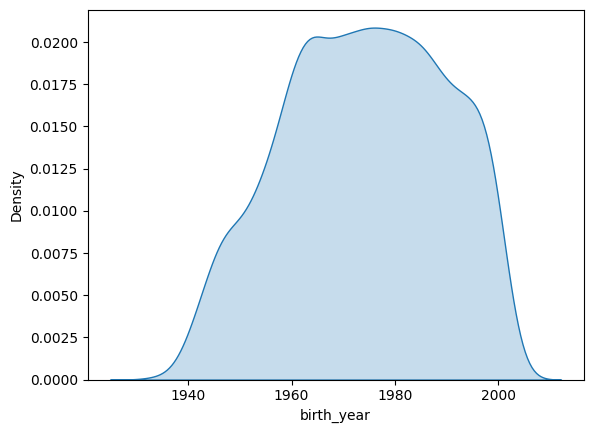

In [30]:
# Kernel Density Estimation
seaborn.kdeplot(df_cyclists["birth_year"], fill=True, label="birth_year")
plt.show()

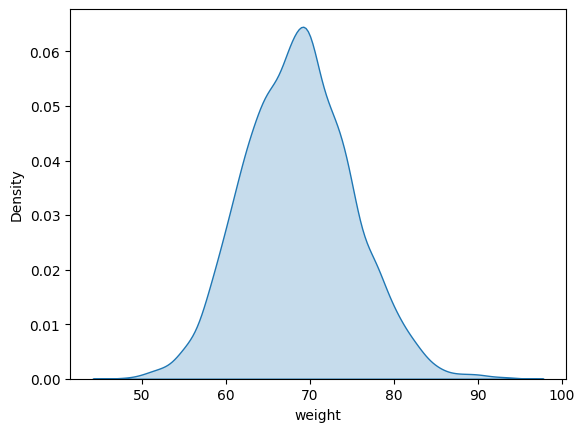

In [31]:
seaborn.kdeplot(df_cyclists["weight"], fill=True, label="weight")
plt.show()

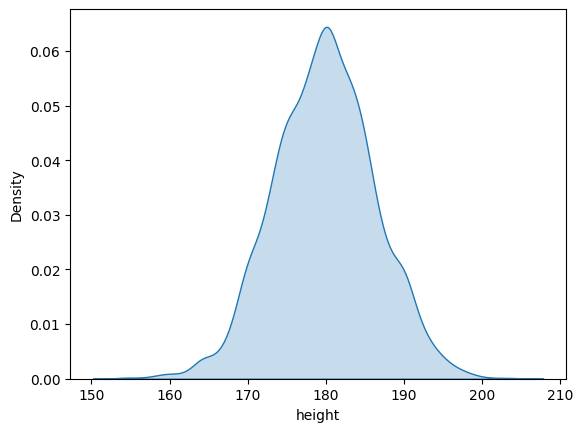

In [32]:
seaborn.kdeplot(df_cyclists["height"], fill=True, label="height")
plt.show()

## Compute optimal number of bins

In [34]:
# Sturges rule for approximately Normal distributions
def sturges_bin_count(df_cyclists):
    """Calculate optimal number of bins based on Sturges' rule"""
    return int(np.ceil(np.log2(len(df_cyclists)) + 1))

bins = sturges_bin_count(df_cyclists["weight"])
print(f"Recommended number of bins: {bins}")

# Freedman-Diaconis Rule is better for data with outliers and skewed distributions
def freedman_diaconis_bin_count(data):
    """Calculate optimal number of bins based on Freedman-Diaconis rule"""
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * iqr * len(data) ** (-1/3)
    return int(np.ceil((data.max() - data.min()) / bin_width))

bins = freedman_diaconis_bin_count(df_cyclists["weight"])
print(f"Recommended number of bins: {bins}")

Recommended number of bins: 14


ValueError: cannot convert float NaN to integer

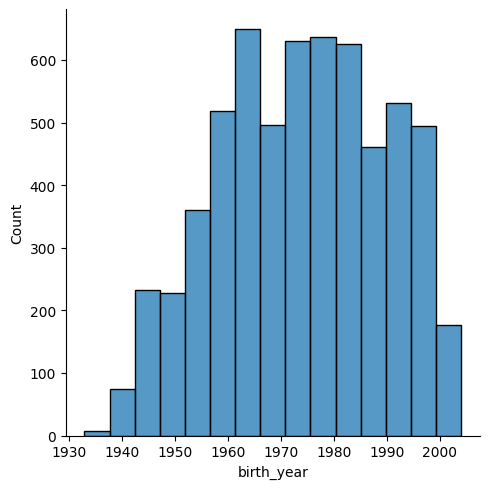

In [35]:
# birht year
seaborn.displot(df_cyclists,
                x="birth_year",
                kind="hist",
                row_order="desc",
                bins=15)

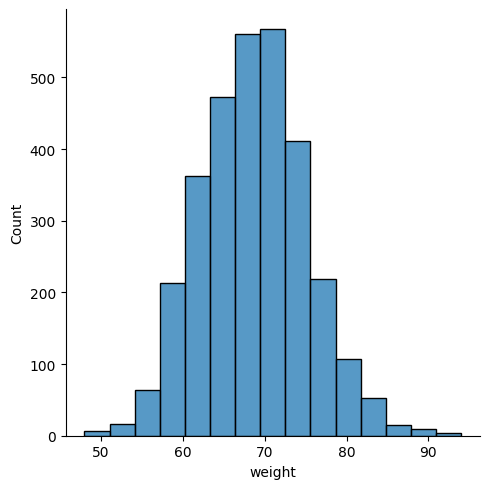

In [36]:
# weight
seaborn.displot(df_cyclists,
                x="weight",
                kind="hist",
                row_order="desc",
                bins=14)

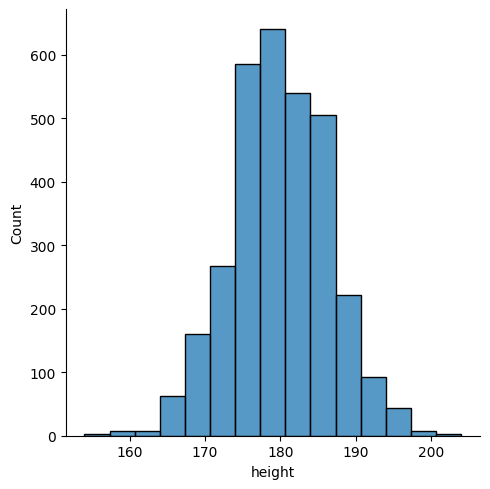

In [37]:
# height
seaborn.displot(df_cyclists,
                x="height",
                kind="hist",
                row_order="desc",
                bins=14)

## SimpleImputer for birth year
It seems good wrt the distribution. Since they are only 13, we keep that

In [33]:
# try simple imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit((df_cyclists[["birth_year"]]))
df_cyclists["birth_year"] = imputer.transform(df_cyclists[["birth_year"]]).squeeze()

In [34]:
df_cyclists.isnull().sum() # zero missing values for birth year

_url              0
name              0
birth_year        0
weight         3055
height         2990
nationality       0
dtype: int64

### Review distribution of birth year --> OKAY seems reasonably the same

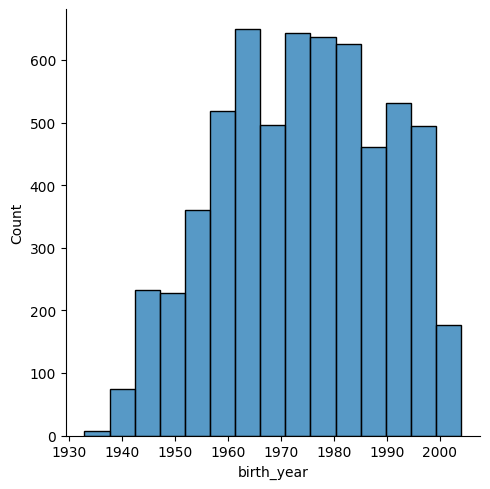

In [35]:
# review distribution of birth year --> OKAY seems reasonably the same
seaborn.displot(df_cyclists,
                x="birth_year",
                kind="hist",
                row_order="desc",
                bins=15)

# KNN imputer test for weight

In [108]:
# try simple imputer
from sklearn.impute import KNNImputer

# create test dataset for testing weight and height replacement with KNN
test_df_cyclists = df_cyclists
imputer = KNNImputer(n_neighbors=2,weights="distance")
imputer.fit((test_df_cyclists[["weight"]]))
test_df_cyclists["weight"] = imputer.transform(test_df_cyclists[["weight"]]).squeeze()

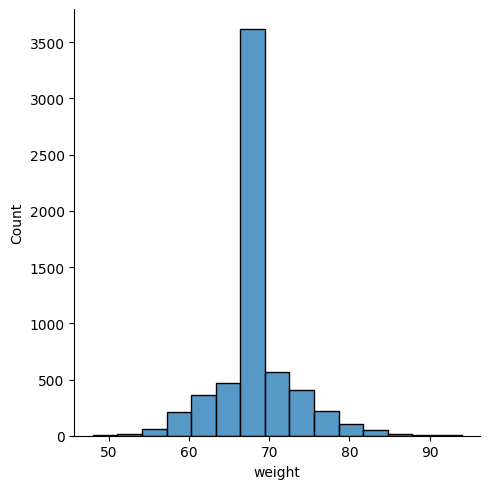

In [109]:
# review distribution of weight --> NOT GOOD 
seaborn.displot(test_df_cyclists,
                x="weight",
                kind="hist",
                row_order="desc",
                bins=15)

## Iterative Imputer for weight

Flexibility of IterativeImputer
There are many well-established imputation packages in the R data science ecosystem: Amelia, mi, mice, missForest, etc. missForest is popular, and turns out to be a particular instance of different sequential imputation algorithms that can all be implemented with IterativeImputer by passing in different regressors to be used for predicting missing feature values.

Multiple vs. Single Imputation
In the statistics community, it is common practice to perform multiple imputations, generating, for example, m separate imputations for a single feature matrix. Each of these m imputations is then put through the subsequent analysis pipeline (e.g. feature engineering, clustering, regression, classification). The m final analysis results (e.g. held-out validation errors) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. The above practice is called multiple imputation.

Our implementation of IterativeImputer was inspired by the R MICE package (Multivariate Imputation by Chained Equations) [1], but differs from it by returning a single imputation instead of multiple imputations. However, IterativeImputer can also be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds when sample_posterior=True

Multiple imputation --> different datasets generated

The parameter sample_posterior in sklearn's IterativeImputer is directly related to multiple imputation. Let's break it down:

Iterative Imputer: This method models each feature with missing values as a function of other features, and iteratively imputes the missing values.

Posterior Distribution: The term "posterior" in this context refers to the posterior distribution of the missing data. When sample_posterior=True, it draws imputed values from the posterior distribution of the predicted values, which adds randomness (or variability) to the imputed values. This means that for the same missing value, multiple imputations will yield different (randomly sampled) values, thus generating multiple plausible datasets.

When sample_posterior=True: The imputed values are not just the most likely (expected) value but are randomly sampled from the predicted distribution. This randomness is important in multiple imputation because it reflects the uncertainty about the imputed values.

In [38]:
df_cyclists_impute = df_cyclists[['height', 'weight']].copy()

print("Shape of original DataFrame:", df_cyclists.shape)
print("Shape of imputed DataFrame:", df_cyclists_impute.shape)
# Step 2: Normalize/Scale the relevant features (birth_year, height)
#scaler = StandardScaler()
#df_cyclists_impute[['birth_year', 'height']] = scaler.fit_transform(df_cyclists_impute[['birth_year', 'height']])

iterative_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=0,
    max_iter=100,
    sample_posterior=True
)

# Fit the imputer and transform the DataFrame
imputed_values = iterative_imputer.fit_transform(df_cyclists_impute)
# Create a new DataFrame with the imputed values
df_imputed = pd.DataFrame(imputed_values, columns=df_cyclists_impute.columns)

# Display the original and imputed DataFrames
#print("Original DataFrame:\n", df_cyclists)
print("\nImputed DataFrame:\n", df_imputed)

Shape of original DataFrame: (6133, 6)
Shape of imputed DataFrame: (6133, 2)

Imputed DataFrame:
           height     weight
0     187.597309  69.812385
1     182.000000  74.000000
2     189.000000  69.000000
3     192.000000  78.000000
4     171.000000  55.000000
...          ...        ...
6128  187.722968  72.047719
6129  188.000000  75.000000
6130  166.849741  58.058737
6131  170.000000  58.000000
6132  186.000000  75.000000

[6133 rows x 2 columns]


In [39]:
# check len of new imputed data
len(df_imputed)

6133

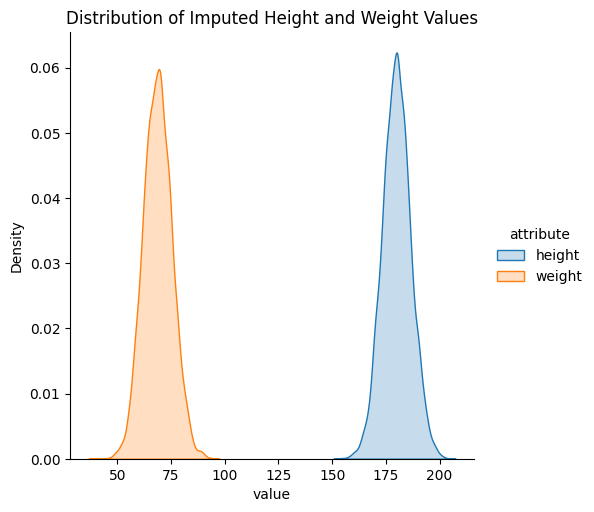

In [40]:
# Visualize the distributions of imputed height and weight
df_long = pd.melt(df_imputed, value_vars=['height', 'weight'], var_name='attribute', value_name='value')

seaborn.displot(df_long, x='value', hue='attribute', kind='kde', fill=True, common_norm=False)
plt.title('Distribution of Imputed Height and Weight Values')
plt.show()

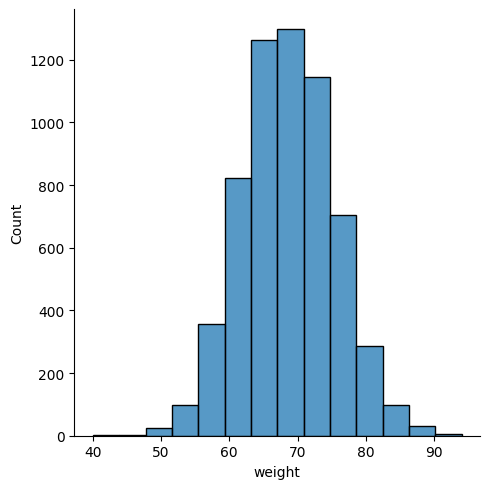

In [43]:
# review distribution of weight --> GOOD 
seaborn.displot(df_imputed,
                x="weight",
                kind="hist",
                row_order="desc",
                bins=14)

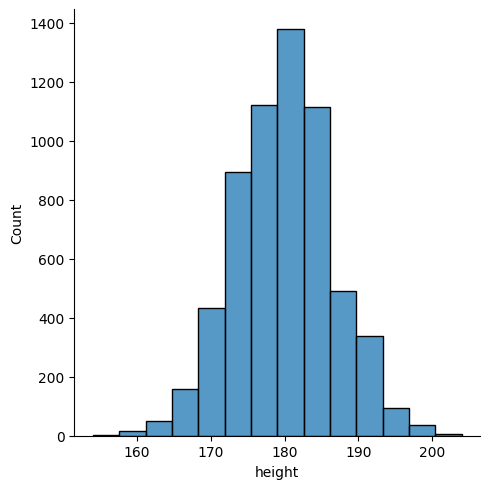

In [44]:
# review distribution of height --> GOOD
seaborn.displot(df_imputed,
                x="height",
                kind="hist",
                row_order="desc",
                bins=14)

### Distributions are pretty good --> TODO: adjust estimators/parameters and try different models for iterative imputer (regression / knn + hyperparameters tuning)

1. Try standardizing data

In [53]:
df_cyclists_impute_scaling = df_cyclists[['height', 'weight']].copy()

print("Shape of original DataFrame:", df_cyclists.shape)
print("Shape of imputed DataFrame:", df_cyclists_impute_scaling.shape)

# Normalize/Scale 
scaler = StandardScaler()
df_cyclists_impute_scaling[['weight', 'height']] = scaler.fit_transform(df_cyclists_impute_scaling[['weight', 'height']])

iterative_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=0,
    max_iter=100,
    sample_posterior=True
)

# Fit the imputer and transform the DataFrame
imputed_values = iterative_imputer.fit_transform(df_cyclists_impute_scaling)
# Create a new DataFrame with the imputed values
df_imputed_scaling = pd.DataFrame(imputed_values, columns=df_cyclists_impute_scaling.columns)

# revert scaling
df_imputed_scaling = pd.DataFrame(
    scaler.inverse_transform(df_imputed_scaling),  
    columns=df_imputed_scaling.columns
)

# Display the original and imputed DataFrames
#print("Original DataFrame:\n", df_cyclists_impute_scaling)
print("\nImputed DataFrame:\n", df_imputed_scaling)

Shape of original DataFrame: (6133, 6)
Shape of imputed DataFrame: (6133, 2)

Imputed DataFrame:
          height      weight
0     75.957074  181.234462
1     70.811285  185.236578
2     77.707768  180.161528
3     80.663404  189.296618
4     59.973954  165.951387
...         ...         ...
6128  76.166234  183.313649
6129  76.722556  186.251588
6130  56.882074  169.916741
6131  58.988742  168.996417
6132  74.752133  186.251588

[6133 rows x 2 columns]


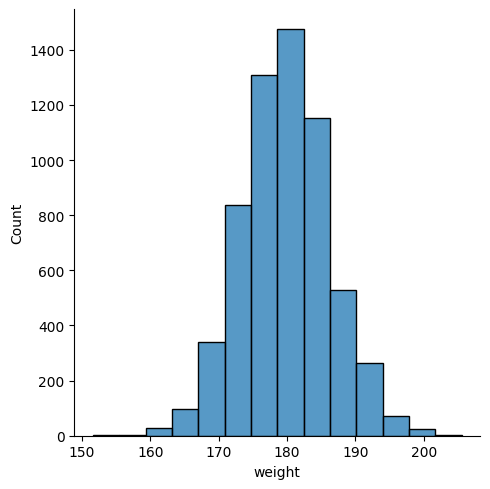

In [55]:
# review distribution of weight --> GOOD 
seaborn.displot(df_imputed_scaling,
                x="weight",
                kind="hist",
                row_order="desc",
                bins=14)

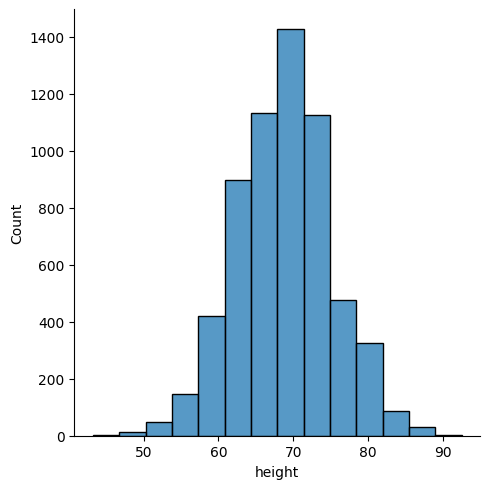

In [56]:
# review distribution of height --> GOOD 
seaborn.displot(df_imputed_scaling,
                x="height",
                kind="hist",
                row_order="desc",
                bins=14)

2. Try another model --> random forest (non linear)
3. Tune tolerance and max iteration parameters of the imputator

In [73]:
df_cyclists_impute_scaling_rf = df_cyclists[['height', 'weight']].copy()

print("Shape of original DataFrame:", df_cyclists.shape)
print("Shape of imputed DataFrame:", df_cyclists_impute_scaling_rf.shape)

# Normalize/Scale 
scaler = StandardScaler()
df_cyclists_impute_scaling_rf[['weight', 'height']] = scaler.fit_transform(df_cyclists_impute_scaling_rf[['weight', 'height']])

iterative_imputer = IterativeImputer(
    estimator=RandomForestRegressor(),
    random_state=0,
    max_iter=400,
    sample_posterior=False
)

# Fit the imputer and transform the DataFrame
imputed_values = iterative_imputer.fit_transform(df_cyclists_impute_scaling_rf)
# Create a new DataFrame with the imputed values
df_imputed_scaling_rf = pd.DataFrame(imputed_values, columns=df_cyclists_impute_scaling_rf.columns)

# revert scaling
df_imputed_scaling_rf = pd.DataFrame(
    scaler.inverse_transform(df_imputed_scaling_rf),  
    columns=df_imputed_scaling_rf.columns
)

# Display the original and imputed DataFrames
#print("Original DataFrame:\n", df_cyclists_impute_scaling)
print("\nImputed DataFrame:\n", df_imputed_scaling_rf)

Shape of original DataFrame: (6133, 6)
Shape of imputed DataFrame: (6133, 2)


KeyboardInterrupt: 